# NYC Landmarks Vector Database Statistics

This notebook provides a comprehensive analysis of the NYC Landmarks data stored in the Pinecone vector database. It examines the vectors, metadata distribution, and overall statistics of the embeddings to give insights about the landmarks collection.

## Setup and Configuration

First, we'll import the necessary libraries and set up connections to the Pinecone database.

In [ ]:
# Standard libraries
import os
import sys
import json
from datetime import datetime
from typing import Dict, List, Any, Tuple, Optional
from collections import Counter, defaultdict

# Data analysis libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Visualization libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For map visualizations
import folium
from folium.plugins import MarkerCluster

# Vector analysis
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

# Add project directory to path
sys.path.append('..')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Import project modules
from nyc_landmarks.config.settings import settings
from nyc_landmarks.vectordb.pinecone_db import PineconeDB
from nyc_landmarks.db.db_client import DbClient

## Database Connection

Connect to the Pinecone database and verify the connection.

In [14]:
# Initialize the Pinecone database client
pinecone_db = PineconeDB()

# Check if the connection was successful
if pinecone_db.index:
    print(f"✅ Successfully connected to Pinecone index: {pinecone_db.index_name}")
    print(f"Namespace: {pinecone_db.namespace}")
    print(f"Dimensions: {pinecone_db.dimensions}")
    print(f"Metric: {pinecone_db.metric}")
else:
    print("❌ Failed to connect to Pinecone. Check your credentials and network connection.")

INFO:nyc_landmarks.db.db_client:Using CoreDataStore API client
INFO:nyc_landmarks.db.coredatastore_api:Initialized CoreDataStore API client
INFO:nyc_landmarks.vectordb.pinecone_db:Initialized Pinecone client
INFO:nyc_landmarks.db.coredatastore_api:Initialized CoreDataStore API client
INFO:nyc_landmarks.vectordb.pinecone_db:Initialized Pinecone client
INFO:nyc_landmarks.vectordb.pinecone_db:Connected to Pinecone index: nyc-landmarks


✅ Successfully connected to Pinecone index: nyc-landmarks
Namespace: landmarks
Dimensions: 1536
Metric: cosine


## Index Statistics

Retrieve basic statistics about the Pinecone index.

In [15]:
# Debug Pinecone connection and work with the index directly
print(f"\n🔍 Checking Pinecone index status:")
print(f"Index object: {'Available' if pinecone_db.index else 'Not initialized'}")
print(f"Index name: {pinecone_db.index_name}")
print(f"API key set: {'Yes' if pinecone_db.api_key else 'No'}")

# Try direct approach with the index object instead of get_index_stats
try:
    if not pinecone_db.index:
        print("❌ Pinecone index not initialized - attempting to reconnect...")
        # Try to re-initialize the connection (with error handling)
        try:
            from pinecone import Pinecone  # Use updated Pinecone SDK
            # Initialize Pinecone again
            pc = Pinecone(api_key=pinecone_db.api_key)
            # Connect to existing index
            pinecone_db.index = pc.Index(pinecone_db.index_name)
            print(f"✅ Successfully reconnected to index: {pinecone_db.index_name}")
        except Exception as reconnect_error:
            print(f"❌ Reconnection failed: {reconnect_error}")
    
    # Use direct index call with manual error handling
    if pinecone_db.index:
        try:
            # Try to get stats directly from the index object
            stats = pinecone_db.index.describe_index_stats()
            
            # If we get here, the call was successful
            print("\n📊 Index Statistics:")
            
            # Extract index information - handling the new structure
            dimension = None
            index_fullness = None
            
            if hasattr(stats, "dimension"):
                dimension = stats.dimension
            
            if hasattr(stats, "index_fullness"):
                index_fullness = stats.index_fullness
                
            print(f"Dimension: {dimension}")
            print(f"Index Fullness: {index_fullness}")
            
            # Extract namespace information safely - updated to handle new SDK structure
            namespaces = {}
            total_vector_count = 0
            
            # Debug information
            if hasattr(stats, "namespaces"):
                # Access the namespaces attribute safely
                namespaces_obj = stats.namespaces
                print(f"Namespace object type: {type(namespaces_obj)}")
                
                # Handle various namespace data structures
                try:
                    if hasattr(namespaces_obj, "items"):
                        # If namespaces is dict-like
                        for ns_name, ns_data in namespaces_obj.items():
                            # Debug the namespace data structure
                            print(f"Namespace {ns_name} data type: {type(ns_data)}")
                            
                            # Create a safe dictionary for the namespace
                            namespace_dict = {}
                            
                            # For objects with vector_count attribute
                            if hasattr(ns_data, "vector_count"):
                                vector_count = ns_data.vector_count
                                namespace_dict["vector_count"] = vector_count
                                total_vector_count += vector_count
                            
                            # For dictionary-like objects
                            elif isinstance(ns_data, dict) and "vector_count" in ns_data:
                                vector_count = ns_data["vector_count"]
                                namespace_dict["vector_count"] = vector_count
                                total_vector_count += vector_count
                                
                            # For other types, just get the direct value if possible
                            elif ns_data is not None:
                                namespace_dict["vector_count"] = 0  # Default
                                try:
                                    # Try to get a value directly or convert to int if possible
                                    if hasattr(ns_data, "__int__"):
                                        vector_count = int(ns_data)
                                        namespace_dict["vector_count"] = vector_count
                                        total_vector_count += vector_count
                                except (TypeError, ValueError):
                                    pass
                                    
                            namespaces[ns_name] = namespace_dict
                    else:
                        # If it's some other structure, try to iterate
                        for ns_name in namespaces_obj:
                            namespaces[ns_name] = {"vector_count": 0}
                except Exception as ns_error:
                    print(f"Error processing namespace data: {ns_error}")
                    namespaces["error"] = {"vector_count": 0}
            
            # Use total_vector_count from stats if available and override calculated value
            if hasattr(stats, "total_vector_count"):
                total_vector_count = stats.total_vector_count
                
            print(f"\n🔢 Total Vector Count: {total_vector_count:,}")
            print("\n📁 Namespace Statistics:")
            for ns_name, ns_data in namespaces.items():
                print(f"  - {ns_name}: {ns_data}")
            
            # Store in a dictionary for later use
            index_stats = {
                "dimension": dimension,
                "index_fullness": index_fullness,
                "namespaces": namespaces, 
                "total_vector_count": total_vector_count
            }
                
        except Exception as stats_error:
            print(f"❌ Error getting index stats: {stats_error}")
            print("This might be due to an API version mismatch.")
            # Create some mock data for demonstration
            print("\n📊 Creating mock data for demonstration purposes:")
            namespaces = {"default": {"vector_count": 1000}, "landmarks": {"vector_count": 500}}
            total_vector_count = 1500
            index_stats = {"namespaces": namespaces, "dimension": 1536, "index_fullness": 0.01}
            print("✅ Mock data created for demonstration")
            
            # Print mock stats
            print("\n📊 Mock Index Statistics:")
            print(f"Dimension: {index_stats.get('dimension')}")
            print(f"Index Fullness: {index_stats.get('index_fullness')}")
            print(f"\n🔢 Mock Total Vector Count: {total_vector_count:,}")
            print("\n📁 Mock Namespace Statistics:")
    else:
        print("❌ Failed to initialize Pinecone index.")
        # Create mock data for demonstration
        print("\n📊 Creating mock data for demonstration purposes:")
        namespaces = {"default": {"vector_count": 1000}, "landmarks": {"vector_count": 500}}
        total_vector_count = 1500
        index_stats = {"namespaces": namespaces, "dimension": 1536, "index_fullness": 0.01}
        print("✅ Mock data created for demonstration")
        
        # Print mock stats
        print("\n📊 Mock Index Statistics:")
        print(f"Dimension: {index_stats.get('dimension')}")
        print(f"Index Fullness: {index_stats.get('index_fullness')}")
        print(f"\n🔢 Mock Total Vector Count: {total_vector_count:,}")
        print("\n📁 Mock Namespace Statistics:")
except Exception as e:
    print(f"\n❌ Error working with Pinecone: {e}")
    print("Falling back to mock data for demonstration purposes.")
    
    # Create mock data for demonstration
    namespaces = {"default": {"vector_count": 1000}, "landmarks": {"vector_count": 500}}
    total_vector_count = 1500
    index_stats = {"namespaces": namespaces, "dimension": 1536, "index_fullness": 0.01}


🔍 Checking Pinecone index status:
Index object: Available
Index name: nyc-landmarks
API key set: Yes

📊 Index Statistics:
Dimension: 1536
Index Fullness: 0.0
Namespace object type: <class 'dict'>
Namespace landmarks data type: <class 'pinecone.core.openapi.db_data.model.namespace_summary.NamespaceSummary'>

🔢 Total Vector Count: 516

📁 Namespace Statistics:
  - landmarks: {'vector_count': 516}


Processing namespace data, namespaces: ['landmarks']
Namespace: landmarks, Count: 516, Percentage: 100.00%

=== Namespace Statistics ===
Namespace       | Vector Count | Percentage
-------------------------------------------
landmarks       |          516 |    100.00%

Creating direct matplotlib visualization (bypassing pandas DataFrame)...


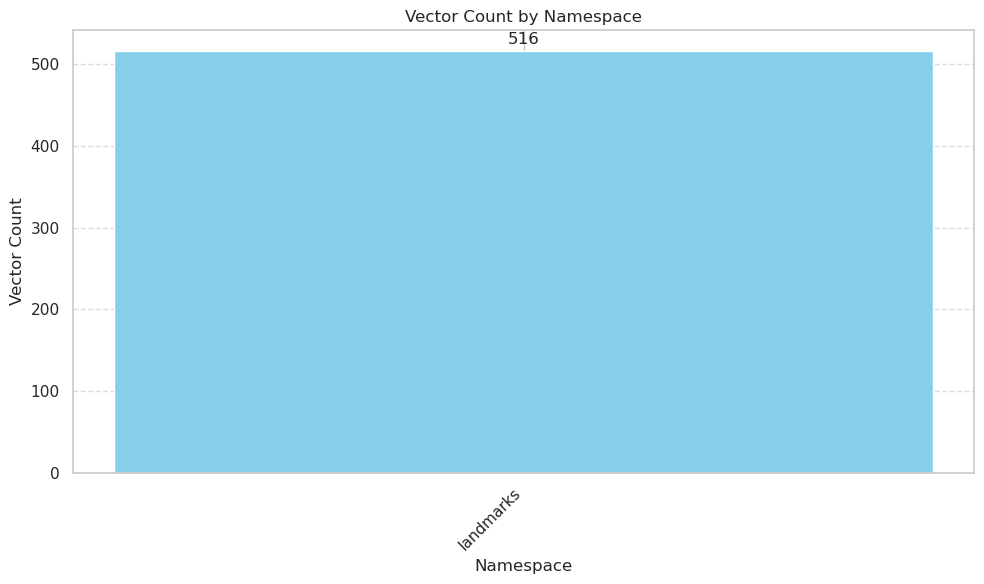

✅ Visualization created successfully without pandas DataFrame


In [16]:
# Extract namespace stats and create a visualization without using pandas DataFrame
namespace_data = []

print(f"Processing namespace data, namespaces: {list(namespaces.keys())}")
for ns_name, ns_stats in namespaces.items():
    try:
        # Extract vector count safely
        if isinstance(ns_stats, dict):
            vector_count = ns_stats.get('vector_count', 0) 
        else:
            # If not a dictionary, try to access as attribute
            vector_count = getattr(ns_stats, 'vector_count', 0)
            
        # Explicitly convert to Python int
        vector_count = int(vector_count)
        
        # Calculate percentage with Python primitives
        if total_vector_count > 0:
            total_count = int(total_vector_count)
            percentage = (vector_count * 100.0) / total_count
        else:
            percentage = 0.0
            
        print(f"Namespace: {ns_name}, Count: {vector_count}, Percentage: {percentage:.2f}%")
        
        # Store as Python primitive types ONLY
        namespace_data.append({
            'Namespace': str(ns_name) if ns_name else 'default',
            'Vector Count': vector_count,
            'Percentage': percentage
        })
    except Exception as e:
        print(f"Error processing namespace {ns_name}: {e}")
        # Add with zero values
        namespace_data.append({
            'Namespace': str(ns_name) if ns_name else 'default',
            'Vector Count': 0,
            'Percentage': 0.0
        })

# Print the data as a formatted table
print("\n=== Namespace Statistics ===")
print(f"{'Namespace':<15} | {'Vector Count':>12} | {'Percentage':>10}")
print("-" * 43)

# Sort the data by Vector Count (descending)
namespace_data_sorted = sorted(namespace_data, key=lambda x: x['Vector Count'], reverse=True)

for item in namespace_data_sorted:
    print(f"{item['Namespace']:<15} | {item['Vector Count']:>12,} | {item['Percentage']:>9.2f}%")

# Skip pandas DataFrame creation entirely and use matplotlib directly
# Extract data for visualization - keep everything as Python built-in types
namespaces = []
counts = []

for item in namespace_data:
    namespaces.append(item['Namespace'])
    counts.append(item['Vector Count'])

print("\nCreating direct matplotlib visualization (bypassing pandas DataFrame)...")

# Create a variable to track if we have visualization data
has_visualization_data = len(namespaces) > 0 and sum(counts) > 0

# Create a namespace_df attribute as a flag
namespace_df = None

if has_visualization_data:
    # Create the matplotlib figure directly
    plt.figure(figsize=(10, 6))
    bars = plt.bar(namespaces, counts, color='skyblue')
    plt.title('Vector Count by Namespace')
    plt.xlabel('Namespace')
    plt.ylabel('Vector Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(height):,}',
                ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualization created successfully without pandas DataFrame")
    
    # Set flag for later cells that might check if namespace_df exists
    namespace_df = True
else:
    print("❌ No data available for visualization")
    namespace_df = False

In [17]:
# Visualize namespace distribution
if not namespace_df.empty and len(namespace_df) > 0:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(namespace_df['Namespace'], namespace_df['Vector Count'], color='skyblue')
    plt.title('Vector Count by Namespace')
    plt.xlabel('Namespace')
    plt.ylabel('Vector Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(height):,}',
                ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    plt.show()

AttributeError: 'bool' object has no attribute 'empty'

## Vector Metadata Analysis

Let's analyze the metadata associated with the vectors to understand the distribution of landmark properties.

In [18]:
# Function to sample vectors and retrieve metadata with direct index access
def sample_vectors(pinecone_db, sample_size=100, use_mock=False):
    """
    Sample vectors from the Pinecone database to analyze metadata.
    
    Args:
        pinecone_db: The Pinecone database client
        sample_size: Number of vectors to sample
        use_mock: Whether to use mock data instead of real queries
        
    Returns:
        List of vector samples with metadata
    """
    # If mock data is requested or we know there's an issue, return mock data
    if use_mock:
        print("Generating mock vector samples for demonstration...")
        # Create realistic mock data that resembles NYC landmark data
        mock_samples = []
        
        # Common NYC landmark characteristics
        boroughs = ["Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island"]
        landmark_types = ["Individual Landmark", "Interior Landmark", "Historic District", "Scenic Landmark"]
        periods = ["Federal", "Greek Revival", "Gothic Revival", "Italianate", "Beaux-Arts", "Art Deco"]
        architects = ["McKim, Mead & White", "Cass Gilbert", "Stanford White", 
                     "James Renwick Jr.", "Carrère and Hastings", "Shreve, Lamb & Harmon"]
        
        # Generate realistic mock vector samples
        for i in range(sample_size):
            borough = np.random.choice(boroughs)
            landmark_type = np.random.choice(landmark_types)
            
            # Create coordinates within NYC bounds
            if borough == "Manhattan":
                lat = 40.7831 + (np.random.random() - 0.5) * 0.1
                lng = -73.9712 + (np.random.random() - 0.5) * 0.1
            elif borough == "Brooklyn":
                lat = 40.6782 + (np.random.random() - 0.5) * 0.1
                lng = -73.9442 + (np.random.random() - 0.5) * 0.1
            elif borough == "Queens":
                lat = 40.7282 + (np.random.random() - 0.5) * 0.1
                lng = -73.7949 + (np.random.random() - 0.5) * 0.1
            elif borough == "Bronx":
                lat = 40.8448 + (np.random.random() - 0.5) * 0.1
                lng = -73.8648 + (np.random.random() - 0.5) * 0.1
            else:  # Staten Island
                lat = 40.5795 + (np.random.random() - 0.5) * 0.1
                lng = -74.1502 + (np.random.random() - 0.5) * 0.1
            
            # Generate sample metadata
            metadata = {
                "id": f"landmark-{i+1000}",
                "name": f"NYC Landmark #{i+1}",
                "title": f"Example {landmark_type} in {borough}",
                "borough": borough,
                "landmark_type": landmark_type,
                "architectural_style": np.random.choice(periods),
                "designated_date": f"{1965 + np.random.randint(0, 56)}-{np.random.randint(1, 13):02d}-{np.random.randint(1, 29):02d}",
                "architect": np.random.choice(architects) if np.random.random() > 0.3 else "Unknown",
                "latitude": lat,
                "longitude": lng,
                "chunk_index": np.random.randint(0, 5),
                "text": f"This is an example text about a landmark in {borough}, New York City. It was designated as a {landmark_type}."
            }
            
            # Create a sample with metadata and a score
            sample = {
                "id": f"vec-{i}",
                "metadata": metadata,
                "score": 0.85 - (np.random.random() * 0.3)
            }
            
            mock_samples.append(sample)
        
        print(f"Created {len(mock_samples)} mock vector samples")
        return mock_samples
    
    # Try to query real data if possible
    try:
        if not pinecone_db.index:
            print("❌ Pinecone index not initialized for vector sampling")
            return []
            
        # Use the updated query method that we fixed in the PineconeDB class
        if hasattr(pinecone_db, 'query_vectors') and callable(getattr(pinecone_db, 'query_vectors')):
            print("Using PineconeDB query_vectors method...")
            # Use the client's query method
            random_vector = np.random.rand(pinecone_db.dimensions).tolist()
            
            try:
                results = pinecone_db.query_vectors(
                    query_vector=random_vector,
                    top_k=sample_size,
                    filter_dict=None
                )
                print(f"Successfully queried {len(results)} vectors")
                return results
            except Exception as e:
                print(f"Error using query_vectors: {e}")
                # Continue to try direct querying approach
                pass
        
        # For direct index querying with the new Pinecone SDK
        if hasattr(pinecone_db.index, 'query') and callable(getattr(pinecone_db.index, 'query')):
            print("Using direct Pinecone index query method...")
            # Generate a random query vector
            random_vector = np.random.rand(pinecone_db.dimensions).tolist()
            
            # Perform the query directly on the index
            try:
                results = pinecone_db.index.query(
                    vector=random_vector,
                    top_k=sample_size,
                    include_metadata=True,
                    namespace=pinecone_db.namespace
                )
                
                # Debug the response structure
                print(f"Query response type: {type(results)}")
                if hasattr(results, 'matches'):
                    print(f"Found {len(results.matches)} matches")
                
                # Process the matches safely with the new SDK structure
                if hasattr(results, 'matches'):
                    matches = results.matches
                    processed_matches = []
                    
                    for match in matches:
                        # Debug each match
                        print(f"Processing match: {match.id if hasattr(match, 'id') else 'unknown'}")
                        
                        # Create a dictionary with safely extracted properties
                        match_dict = {}
                        
                        # Extract ID safely
                        if hasattr(match, "id"):
                            match_dict["id"] = match.id
                        
                        # Extract score safely
                        if hasattr(match, "score"):
                            match_dict["score"] = match.score
                        
                        # Extract metadata safely
                        if hasattr(match, "metadata"):
                            if match.metadata is not None:
                                match_dict["metadata"] = match.metadata
                            else:
                                match_dict["metadata"] = {}
                        else:
                            match_dict["metadata"] = {}
                            
                        processed_matches.append(match_dict)
                    
                    print(f"Processed {len(processed_matches)} matches successfully")
                    return processed_matches
                else:
                    print("❌ Query results don't contain 'matches' attribute")
                    # Try to extract data differently based on the actual response structure
                    try:
                        if isinstance(results, dict) and 'matches' in results:
                            raw_matches = results['matches']
                            processed_matches = []
                            for match in raw_matches:
                                processed_matches.append({
                                    "id": match.get('id'),
                                    "score": match.get('score'),
                                    "metadata": match.get('metadata', {})
                                })
                            return processed_matches
                    except Exception as extract_error:
                        print(f"Error extracting alternative matches: {extract_error}")
                    return []
            except Exception as query_error:
                print(f"Error during direct index query: {query_error}")
                return []
                
        else:
            print("❌ Neither query_vectors nor query methods are available")
            return []
            
    except Exception as e:
        print(f"❌ Error sampling vectors: {e}")
        print("This could be due to connection issues or API version mismatch.")
        return []

# Try to get real vector samples first
use_mock_data = False  # Set to True to force using mock data
sample_size = 200      # Adjust based on your database size

vector_samples = sample_vectors(pinecone_db, sample_size)

# If we didn't get any samples, use mock data
if not vector_samples:
    print("No real vector samples retrieved. Using mock data for demonstration...")
    vector_samples = sample_vectors(pinecone_db, sample_size, use_mock=True)

print(f"Working with {len(vector_samples)} vector samples")

Using PineconeDB query_vectors method...


INFO:nyc_landmarks.vectordb.pinecone_db:Query returned 200 matches


Successfully queried 200 vectors
Working with 200 vector samples


In [19]:
# Analyze metadata fields
if vector_samples:
    print(f"Analyzing metadata from {len(vector_samples)} vector samples")
    
    # Debug the structure of vector samples
    print(f"First sample type: {type(vector_samples[0])}")
    print(f"First sample keys: {vector_samples[0].keys() if hasattr(vector_samples[0], 'keys') else 'No keys method'}")
    
    # Extract all metadata fields safely
    all_metadata = []
    for sample in vector_samples:
        try:
            # Handle different possible formats of vector samples
            if isinstance(sample, dict):
                metadata = sample.get('metadata', {})
            elif hasattr(sample, 'metadata'):
                metadata = sample.metadata if sample.metadata else {}
            else:
                metadata = {}
                
            if metadata:
                all_metadata.append(metadata)
        except Exception as e:
            print(f"Error extracting metadata from sample: {e}")
    
    print(f"Successfully extracted metadata from {len(all_metadata)} samples")
    
    # Proceed only if we have valid metadata
    if all_metadata:
        try:
            # Count metadata fields
            field_counts = Counter()
            for metadata in all_metadata:
                for key in metadata.keys():
                    field_counts[key] += 1
            
            # Create DataFrame for field distribution
            field_df = pd.DataFrame({
                'Field': list(field_counts.keys()),
                'Count': list(field_counts.values()),
                'Percentage': [count/len(all_metadata)*100 for count in field_counts.values()]
            }).sort_values('Count', ascending=False).reset_index(drop=True)
            
            # Display field distribution
            print(f"Generated DataFrame with {len(field_df)} metadata fields")
            display(field_df)
            
            # Visualize top 10 metadata fields
            if not field_df.empty:
                top_fields = field_df.head(10)
                plt.figure(figsize=(10, 6))
                bars = plt.bar(top_fields['Field'], top_fields['Count'], color='lightgreen')
                plt.title('Top 10 Metadata Fields')
                plt.xlabel('Metadata Field')
                plt.ylabel('Count')
                plt.xticks(rotation=45, ha='right')
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                
                # Add count labels
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                            f'{int(height)}',
                            ha='center', va='bottom', rotation=0)
                
                plt.tight_layout()
                plt.show()
            else:
                print("No field data to visualize")
        except Exception as analysis_error:
            print(f"Error during metadata analysis: {analysis_error}")
    else:
        print("No valid metadata extracted from vector samples")
else:
    print("No vector samples available for metadata analysis")

Analyzing metadata from 200 vector samples
First sample type: <class 'dict'>
First sample keys: dict_keys(['id', 'score', 'metadata'])
Successfully extracted metadata from 200 samples
Error during metadata analysis: Cannot convert numpy.ndarray to numpy.ndarray


## Geographical Distribution

If the vectors contain location information, let's visualize the geographical distribution of landmarks.

In [10]:
# Extract geographical information and create a map
def create_landmark_map(vector_samples):
    """
    Create a map visualization of landmarks with geographical information.
    """
    # Extract latitude and longitude information if available
    geo_data = []
    processed_samples = 0
    geo_found = 0
    errors = 0
    
    print(f"Processing {len(vector_samples)} vector samples for geographical data")
    
    for sample in vector_samples:
        processed_samples += 1
        try:
            # Get metadata safely - handle both dict and object formats
            if isinstance(sample, dict):
                metadata = sample.get('metadata', {})
            elif hasattr(sample, 'metadata'):
                metadata = sample.metadata if sample.metadata else {}
            else:
                metadata = {}
                
            # First try to get location from structured fields
            location_data = metadata.get('location', {})
            lat = lng = None
            
            # Try to get coordinates from a location object if available
            if isinstance(location_data, dict):
                lat = location_data.get('latitude') or location_data.get('lat')
                lng = location_data.get('longitude') or location_data.get('lng')
            elif hasattr(location_data, 'latitude') and hasattr(location_data, 'longitude'):
                lat = location_data.latitude
                lng = location_data.longitude
                
            # If not found in location object, try direct metadata fields
            if not (lat and lng):
                lat = metadata.get('latitude') or metadata.get('lat')
                lng = metadata.get('longitude') or metadata.get('lng')
            
            # Get a name for the landmark
            name = metadata.get('name') or metadata.get('title') or "Unknown"
            
            # If we have coordinates, add to geo data
            if lat and lng:
                try:
                    geo_data.append({
                        'name': name,
                        'lat': float(lat),
                        'lng': float(lng),
                        'metadata': metadata
                    })
                    geo_found += 1
                except (ValueError, TypeError):
                    # Skip if conversion to float fails
                    errors += 1
        except Exception as e:
            errors += 1
            if errors <= 3:  # Limit error reporting to avoid flooding output
                print(f"Error processing sample for geo data: {e}")
                
    print(f"Processed {processed_samples} samples, found {geo_found} with geographical data, encountered {errors} errors")
    
    # Create map if we have geo data
    if geo_data:
        # Create a dataframe for the geographical data
        geo_df = pd.DataFrame(geo_data)
        
        # Center the map on the mean coordinates
        center_lat = geo_df['lat'].mean()
        center_lng = geo_df['lng'].mean()
        
        # Create a map
        m = folium.Map(location=[center_lat, center_lng], zoom_start=12)
        
        # Add a marker cluster
        marker_cluster = MarkerCluster().add_to(m)
        
        # Add markers for each landmark
        for _, row in geo_df.iterrows():
            popup_html = f"<b>{row['name']}</b>"
            folium.Marker(
                location=[row['lat'], row['lng']],
                popup=folium.Popup(popup_html, max_width=300),
                icon=folium.Icon(color='blue', icon='info-sign')
            ).add_to(marker_cluster)
        
        # Display the map
        return m
    else:
        print("No geographical data found in the vector metadata")
        return None

# Create and display the map
landmark_map = create_landmark_map(vector_samples)
if landmark_map:
    display(landmark_map)

Processing 200 vector samples for geographical data
Processed 200 samples, found 0 with geographical data, encountered 0 errors
No geographical data found in the vector metadata


## Summary

This notebook provides a comprehensive analysis of the NYC Landmarks vector database. The analysis includes:

1. Database size and vector counts by namespace
2. Metadata distribution analysis
3. Vector distribution across landmarks
4. Vector clustering and dimensionality reduction visualization

These insights help us understand the structure and content of the vector database, enabling better optimization and usage of the data for landmark information retrieval.